In [2]:
import numpy as np
import tensorflow as tf

## Dataset

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets(".", one_hot=True, reshape=False)

Extracting .\train-images-idx3-ubyte.gz
Extracting .\train-labels-idx1-ubyte.gz
Extracting .\t10k-images-idx3-ubyte.gz
Extracting .\t10k-labels-idx1-ubyte.gz


In [3]:
# Parameters
learning_rate = 0.00001
epochs = 10
batch_size = 128

In [4]:
# Number of samples to calculate validation and accuracy
# Decrease this if you're running out of memory to calculate accuracy
test_valid_size = 256

In [5]:
# Network Parameters
n_classes = 10  # MNIST total classes (0-9 digits)
dropout = 0.75  # Dropout, probability to keep units

## Weights and Biases

In [4]:
tf.zeros([64])

<tf.Tensor 'zeros:0' shape=(64,) dtype=float32>

In [6]:
# Store layers weight & bias
weights = {
    'wc1': tf.Variable(tf.random_normal([5, 5, 1, 32])),
    'wc2': tf.Variable(tf.random_normal([5, 5, 32, 64])),
    'wd1': tf.Variable(tf.random_normal([7*7*64, 1024])),
    'out': tf.Variable(tf.random_normal([1024, n_classes]))}

biases = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([n_classes]))}

## Convolutions

<img src="https://d17h27t6h515a5.cloudfront.net/topher/2016/November/581a58be_convolution-schematic/convolution-schematic.gif" alt="Convolution with 3×3 Filter.  Source: http://deeplearning.stanford.edu/wiki/index.php/Feature_extraction_using_convolution" class="index--image--1wh9w" style="width: 263px;">

In [7]:
def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

## Max Pooling

<img src="https://d17h27t6h515a5.cloudfront.net/topher/2016/November/581a57fe_maxpool/maxpool.jpeg" alt="Max Pooling with 2x2 filter and stride of 2.  Source: http://cs231n.github.io/convolutional-networks/" class="index--image--1wh9w" style="width: 560px;">

In [8]:
def maxpool2d(x, k=2):
    return tf.nn.max_pool(
        x,
        ksize=[1, k, k, 1],
        strides=[1, k, k, 1],
        padding='SAME')

## Model

<img src="https://d17h27t6h515a5.cloudfront.net/topher/2016/November/581a64b7_arch/arch.png" alt="Image from Explore The Design Space video" class="index--image--1wh9w" style="width: 560px;">

In [9]:
def conv_net(x, weights, biases, dropout):
    # Layer 1 - 28*28*1 to 14*14*32
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    conv1 = maxpool2d(conv1, k=2)

    # Layer 2 - 14*14*32 to 7*7*64
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    conv2 = maxpool2d(conv2, k=2)

    # Fully connected layer - 7*7*64 to 1024
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, dropout)

    # Output Layer - class prediction - 1024 to 10
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

## Session

In [10]:
# tf Graph input
x = tf.placeholder(tf.float32, [None, 28, 28, 1])
y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32)

# Model
logits = conv_net(x, weights, biases, keep_prob)

# Define loss and optimizer
cost = tf.reduce_mean(\
    tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)\
    .minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initializing the variables
init = tf. global_variables_initializer()

# Launch the graph
with tf.Session() as sess:
    sess.run(init)

    for epoch in range(epochs):
        for batch in range(mnist.train.num_examples//batch_size):
            batch_x, batch_y = mnist.train.next_batch(batch_size)
            sess.run(optimizer, feed_dict={
                x: batch_x,
                y: batch_y,
                keep_prob: dropout})

            # Calculate batch loss and accuracy
            loss = sess.run(cost, feed_dict={
                x: batch_x,
                y: batch_y,
                keep_prob: 1.})
            valid_acc = sess.run(accuracy, feed_dict={
                x: mnist.validation.images[:test_valid_size],
                y: mnist.validation.labels[:test_valid_size],
                keep_prob: 1.})

            print('Epoch {:>2}, Batch {:>3} -'
                  'Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(
                epoch + 1,
                batch + 1,
                loss,
                valid_acc))
            
    # Calculate Test Accuracy
    test_acc = sess.run(accuracy, feed_dict={
        x: mnist.test.images[:test_valid_size],
        y: mnist.test.labels[:test_valid_size],
        keep_prob: 1.})
    print('Testing Accuracy: {}'.format(test_acc))

Epoch  1, Batch   1 -Loss: 61739.2070 Validation Accuracy: 0.125000
Epoch  1, Batch   2 -Loss: 45803.4375 Validation Accuracy: 0.125000
Epoch  1, Batch   3 -Loss: 41492.1562 Validation Accuracy: 0.132812
Epoch  1, Batch   4 -Loss: 36010.0625 Validation Accuracy: 0.132812
Epoch  1, Batch   5 -Loss: 35023.6641 Validation Accuracy: 0.148438
Epoch  1, Batch   6 -Loss: 32702.1211 Validation Accuracy: 0.140625
Epoch  1, Batch   7 -Loss: 32038.6055 Validation Accuracy: 0.144531
Epoch  1, Batch   8 -Loss: 31547.7031 Validation Accuracy: 0.152344
Epoch  1, Batch   9 -Loss: 28309.9102 Validation Accuracy: 0.144531
Epoch  1, Batch  10 -Loss: 27457.3496 Validation Accuracy: 0.148438
Epoch  1, Batch  11 -Loss: 29887.8164 Validation Accuracy: 0.167969
Epoch  1, Batch  12 -Loss: 22409.9258 Validation Accuracy: 0.156250
Epoch  1, Batch  13 -Loss: 25171.6133 Validation Accuracy: 0.152344
Epoch  1, Batch  14 -Loss: 25567.9043 Validation Accuracy: 0.156250
Epoch  1, Batch  15 -Loss: 23275.3750 Validation

Epoch  1, Batch 123 -Loss:  5203.5137 Validation Accuracy: 0.484375
Epoch  1, Batch 124 -Loss:  5636.0000 Validation Accuracy: 0.488281
Epoch  1, Batch 125 -Loss:  4127.6206 Validation Accuracy: 0.492188
Epoch  1, Batch 126 -Loss:  3828.2710 Validation Accuracy: 0.488281
Epoch  1, Batch 127 -Loss:  5035.8110 Validation Accuracy: 0.488281
Epoch  1, Batch 128 -Loss:  5380.5469 Validation Accuracy: 0.511719
Epoch  1, Batch 129 -Loss:  5565.9902 Validation Accuracy: 0.507812
Epoch  1, Batch 130 -Loss:  3897.6426 Validation Accuracy: 0.500000
Epoch  1, Batch 131 -Loss:  4045.3347 Validation Accuracy: 0.507812
Epoch  1, Batch 132 -Loss:  4039.4878 Validation Accuracy: 0.519531
Epoch  1, Batch 133 -Loss:  5313.1304 Validation Accuracy: 0.511719
Epoch  1, Batch 134 -Loss:  3966.0422 Validation Accuracy: 0.503906
Epoch  1, Batch 135 -Loss:  4036.9165 Validation Accuracy: 0.500000
Epoch  1, Batch 136 -Loss:  5133.0083 Validation Accuracy: 0.492188
Epoch  1, Batch 137 -Loss:  4741.3066 Validation

Epoch  1, Batch 245 -Loss:  3473.5911 Validation Accuracy: 0.582031
Epoch  1, Batch 246 -Loss:  2591.6584 Validation Accuracy: 0.585938
Epoch  1, Batch 247 -Loss:  2597.4590 Validation Accuracy: 0.593750
Epoch  1, Batch 248 -Loss:  2898.4368 Validation Accuracy: 0.585938
Epoch  1, Batch 249 -Loss:  2356.4116 Validation Accuracy: 0.589844
Epoch  1, Batch 250 -Loss:  2803.6567 Validation Accuracy: 0.597656
Epoch  1, Batch 251 -Loss:  2504.3057 Validation Accuracy: 0.589844
Epoch  1, Batch 252 -Loss:  2721.5845 Validation Accuracy: 0.589844
Epoch  1, Batch 253 -Loss:  2793.2336 Validation Accuracy: 0.601562
Epoch  1, Batch 254 -Loss:  2435.5247 Validation Accuracy: 0.593750
Epoch  1, Batch 255 -Loss:  2396.0476 Validation Accuracy: 0.605469
Epoch  1, Batch 256 -Loss:  2071.9834 Validation Accuracy: 0.597656
Epoch  1, Batch 257 -Loss:  1913.3071 Validation Accuracy: 0.613281
Epoch  1, Batch 258 -Loss:  2307.4766 Validation Accuracy: 0.593750
Epoch  1, Batch 259 -Loss:  2109.1414 Validation

Epoch  1, Batch 367 -Loss:  1409.5756 Validation Accuracy: 0.656250
Epoch  1, Batch 368 -Loss:  1509.7240 Validation Accuracy: 0.660156
Epoch  1, Batch 369 -Loss:  1778.1451 Validation Accuracy: 0.667969
Epoch  1, Batch 370 -Loss:  1823.4170 Validation Accuracy: 0.667969
Epoch  1, Batch 371 -Loss:  1343.1029 Validation Accuracy: 0.667969
Epoch  1, Batch 372 -Loss:  1666.8665 Validation Accuracy: 0.671875
Epoch  1, Batch 373 -Loss:  1547.6672 Validation Accuracy: 0.664062
Epoch  1, Batch 374 -Loss:  1337.8180 Validation Accuracy: 0.667969
Epoch  1, Batch 375 -Loss:  1603.2855 Validation Accuracy: 0.675781
Epoch  1, Batch 376 -Loss:  1305.4139 Validation Accuracy: 0.675781
Epoch  1, Batch 377 -Loss:  1616.8096 Validation Accuracy: 0.679688
Epoch  1, Batch 378 -Loss:  1675.6139 Validation Accuracy: 0.679688
Epoch  1, Batch 379 -Loss:  1577.0093 Validation Accuracy: 0.671875
Epoch  1, Batch 380 -Loss:  1961.0128 Validation Accuracy: 0.671875
Epoch  1, Batch 381 -Loss:  1946.2539 Validation

Epoch  2, Batch  59 -Loss:  1301.6018 Validation Accuracy: 0.714844
Epoch  2, Batch  60 -Loss:  1221.6082 Validation Accuracy: 0.722656
Epoch  2, Batch  61 -Loss:  1821.8435 Validation Accuracy: 0.722656
Epoch  2, Batch  62 -Loss:  1914.7068 Validation Accuracy: 0.718750
Epoch  2, Batch  63 -Loss:  1505.1659 Validation Accuracy: 0.718750
Epoch  2, Batch  64 -Loss:  2014.7014 Validation Accuracy: 0.722656
Epoch  2, Batch  65 -Loss:  1454.6685 Validation Accuracy: 0.718750
Epoch  2, Batch  66 -Loss:  1469.3102 Validation Accuracy: 0.714844
Epoch  2, Batch  67 -Loss:  1633.8662 Validation Accuracy: 0.714844
Epoch  2, Batch  68 -Loss:  1674.0900 Validation Accuracy: 0.726562
Epoch  2, Batch  69 -Loss:  1968.0592 Validation Accuracy: 0.726562
Epoch  2, Batch  70 -Loss:  1378.9612 Validation Accuracy: 0.734375
Epoch  2, Batch  71 -Loss:  1832.5359 Validation Accuracy: 0.726562
Epoch  2, Batch  72 -Loss:  1397.6154 Validation Accuracy: 0.726562
Epoch  2, Batch  73 -Loss:  1768.8612 Validation

Epoch  2, Batch 181 -Loss:  1010.8321 Validation Accuracy: 0.742188
Epoch  2, Batch 182 -Loss:  1728.4766 Validation Accuracy: 0.746094
Epoch  2, Batch 183 -Loss:  1176.0853 Validation Accuracy: 0.746094
Epoch  2, Batch 184 -Loss:  1009.8690 Validation Accuracy: 0.746094
Epoch  2, Batch 185 -Loss:   919.4856 Validation Accuracy: 0.750000
Epoch  2, Batch 186 -Loss:  1198.1140 Validation Accuracy: 0.742188
Epoch  2, Batch 187 -Loss:  1046.8882 Validation Accuracy: 0.750000
Epoch  2, Batch 188 -Loss:  1040.6799 Validation Accuracy: 0.746094
Epoch  2, Batch 189 -Loss:  1270.1110 Validation Accuracy: 0.742188
Epoch  2, Batch 190 -Loss:  1025.8220 Validation Accuracy: 0.742188
Epoch  2, Batch 191 -Loss:  1319.4768 Validation Accuracy: 0.742188
Epoch  2, Batch 192 -Loss:   873.1799 Validation Accuracy: 0.734375
Epoch  2, Batch 193 -Loss:  1294.2556 Validation Accuracy: 0.742188
Epoch  2, Batch 194 -Loss:   946.8601 Validation Accuracy: 0.738281
Epoch  2, Batch 195 -Loss:  1468.5536 Validation

Epoch  2, Batch 303 -Loss:  1005.2951 Validation Accuracy: 0.726562
Epoch  2, Batch 304 -Loss:   802.3298 Validation Accuracy: 0.726562
Epoch  2, Batch 305 -Loss:  1108.4219 Validation Accuracy: 0.722656
Epoch  2, Batch 306 -Loss:   632.8270 Validation Accuracy: 0.730469
Epoch  2, Batch 307 -Loss:  1345.3550 Validation Accuracy: 0.722656
Epoch  2, Batch 308 -Loss:  1111.3392 Validation Accuracy: 0.730469
Epoch  2, Batch 309 -Loss:   804.4853 Validation Accuracy: 0.738281
Epoch  2, Batch 310 -Loss:  1009.5323 Validation Accuracy: 0.734375
Epoch  2, Batch 311 -Loss:   894.3695 Validation Accuracy: 0.734375
Epoch  2, Batch 312 -Loss:   946.3208 Validation Accuracy: 0.746094
Epoch  2, Batch 313 -Loss:   980.6120 Validation Accuracy: 0.742188
Epoch  2, Batch 314 -Loss:  1026.6470 Validation Accuracy: 0.742188
Epoch  2, Batch 315 -Loss:  1132.0746 Validation Accuracy: 0.734375
Epoch  2, Batch 316 -Loss:  1124.3167 Validation Accuracy: 0.734375
Epoch  2, Batch 317 -Loss:   868.9520 Validation

Epoch  2, Batch 425 -Loss:   702.1538 Validation Accuracy: 0.761719
Epoch  2, Batch 426 -Loss:   757.7606 Validation Accuracy: 0.753906
Epoch  2, Batch 427 -Loss:   972.7346 Validation Accuracy: 0.761719
Epoch  2, Batch 428 -Loss:  1085.4500 Validation Accuracy: 0.757812
Epoch  2, Batch 429 -Loss:  1060.0664 Validation Accuracy: 0.757812
Epoch  3, Batch   1 -Loss:  1196.3157 Validation Accuracy: 0.753906
Epoch  3, Batch   2 -Loss:   863.3621 Validation Accuracy: 0.753906
Epoch  3, Batch   3 -Loss:   844.2765 Validation Accuracy: 0.757812
Epoch  3, Batch   4 -Loss:   600.9414 Validation Accuracy: 0.757812
Epoch  3, Batch   5 -Loss:   835.1841 Validation Accuracy: 0.757812
Epoch  3, Batch   6 -Loss:   996.3003 Validation Accuracy: 0.757812
Epoch  3, Batch   7 -Loss:   917.8931 Validation Accuracy: 0.757812
Epoch  3, Batch   8 -Loss:  1215.7909 Validation Accuracy: 0.761719
Epoch  3, Batch   9 -Loss:  1014.6475 Validation Accuracy: 0.761719
Epoch  3, Batch  10 -Loss:   939.8971 Validation

Epoch  3, Batch 118 -Loss:   728.7745 Validation Accuracy: 0.750000
Epoch  3, Batch 119 -Loss:   915.7683 Validation Accuracy: 0.750000
Epoch  3, Batch 120 -Loss:   910.1956 Validation Accuracy: 0.746094
Epoch  3, Batch 121 -Loss:  1019.1436 Validation Accuracy: 0.750000
Epoch  3, Batch 122 -Loss:   665.0455 Validation Accuracy: 0.746094
Epoch  3, Batch 123 -Loss:   842.7556 Validation Accuracy: 0.757812
Epoch  3, Batch 124 -Loss:   974.6306 Validation Accuracy: 0.753906
Epoch  3, Batch 125 -Loss:   997.6541 Validation Accuracy: 0.757812
Epoch  3, Batch 126 -Loss:   957.7840 Validation Accuracy: 0.753906
Epoch  3, Batch 127 -Loss:   802.6913 Validation Accuracy: 0.753906
Epoch  3, Batch 128 -Loss:   630.0066 Validation Accuracy: 0.757812
Epoch  3, Batch 129 -Loss:   911.4071 Validation Accuracy: 0.753906
Epoch  3, Batch 130 -Loss:  1080.7695 Validation Accuracy: 0.750000
Epoch  3, Batch 131 -Loss:   794.0965 Validation Accuracy: 0.750000
Epoch  3, Batch 132 -Loss:   815.4808 Validation

Epoch  3, Batch 239 -Loss:  1014.1819 Validation Accuracy: 0.753906
Epoch  3, Batch 240 -Loss:   609.7040 Validation Accuracy: 0.753906
Epoch  3, Batch 241 -Loss:   628.4097 Validation Accuracy: 0.761719
Epoch  3, Batch 242 -Loss:   780.3176 Validation Accuracy: 0.753906
Epoch  3, Batch 243 -Loss:   549.5773 Validation Accuracy: 0.757812
Epoch  3, Batch 244 -Loss:   798.0756 Validation Accuracy: 0.761719
Epoch  3, Batch 245 -Loss:   678.7728 Validation Accuracy: 0.757812
Epoch  3, Batch 246 -Loss:   735.5239 Validation Accuracy: 0.761719
Epoch  3, Batch 247 -Loss:   878.7323 Validation Accuracy: 0.757812
Epoch  3, Batch 248 -Loss:   540.9635 Validation Accuracy: 0.750000
Epoch  3, Batch 249 -Loss:   464.9073 Validation Accuracy: 0.750000
Epoch  3, Batch 250 -Loss:   913.0303 Validation Accuracy: 0.750000
Epoch  3, Batch 251 -Loss:   582.2371 Validation Accuracy: 0.746094
Epoch  3, Batch 252 -Loss:   602.7803 Validation Accuracy: 0.746094
Epoch  3, Batch 253 -Loss:   788.6256 Validation

Epoch  3, Batch 360 -Loss:   702.8332 Validation Accuracy: 0.750000
Epoch  3, Batch 361 -Loss:   951.3546 Validation Accuracy: 0.753906
Epoch  3, Batch 362 -Loss:   441.5731 Validation Accuracy: 0.757812
Epoch  3, Batch 363 -Loss:   472.8949 Validation Accuracy: 0.750000
Epoch  3, Batch 364 -Loss:   616.6202 Validation Accuracy: 0.765625
Epoch  3, Batch 365 -Loss:   655.3192 Validation Accuracy: 0.761719
Epoch  3, Batch 366 -Loss:   736.6875 Validation Accuracy: 0.757812
Epoch  3, Batch 367 -Loss:   548.0558 Validation Accuracy: 0.761719
Epoch  3, Batch 368 -Loss:   596.2828 Validation Accuracy: 0.765625
Epoch  3, Batch 369 -Loss:   575.4860 Validation Accuracy: 0.769531
Epoch  3, Batch 370 -Loss:   618.0813 Validation Accuracy: 0.769531
Epoch  3, Batch 371 -Loss:   980.7220 Validation Accuracy: 0.761719
Epoch  3, Batch 372 -Loss:   740.5532 Validation Accuracy: 0.761719
Epoch  3, Batch 373 -Loss:   825.5491 Validation Accuracy: 0.761719
Epoch  3, Batch 374 -Loss:   680.1318 Validation

Epoch  4, Batch  52 -Loss:   374.2340 Validation Accuracy: 0.761719
Epoch  4, Batch  53 -Loss:   805.0406 Validation Accuracy: 0.761719
Epoch  4, Batch  54 -Loss:   715.7728 Validation Accuracy: 0.761719
Epoch  4, Batch  55 -Loss:   735.1497 Validation Accuracy: 0.757812
Epoch  4, Batch  56 -Loss:   533.0477 Validation Accuracy: 0.761719
Epoch  4, Batch  57 -Loss:   886.4855 Validation Accuracy: 0.757812
Epoch  4, Batch  58 -Loss:   646.1306 Validation Accuracy: 0.757812
Epoch  4, Batch  59 -Loss:   836.3001 Validation Accuracy: 0.761719
Epoch  4, Batch  60 -Loss:   451.8724 Validation Accuracy: 0.753906
Epoch  4, Batch  61 -Loss:   687.9695 Validation Accuracy: 0.753906
Epoch  4, Batch  62 -Loss:   497.7176 Validation Accuracy: 0.757812
Epoch  4, Batch  63 -Loss:   503.2244 Validation Accuracy: 0.757812
Epoch  4, Batch  64 -Loss:  1036.3619 Validation Accuracy: 0.757812
Epoch  4, Batch  65 -Loss:   703.7567 Validation Accuracy: 0.765625
Epoch  4, Batch  66 -Loss:   918.6832 Validation

Epoch  4, Batch 173 -Loss:   636.5837 Validation Accuracy: 0.765625
Epoch  4, Batch 174 -Loss:   523.4049 Validation Accuracy: 0.769531
Epoch  4, Batch 175 -Loss:   552.2263 Validation Accuracy: 0.769531
Epoch  4, Batch 176 -Loss:   853.8184 Validation Accuracy: 0.769531
Epoch  4, Batch 177 -Loss:   474.3712 Validation Accuracy: 0.765625
Epoch  4, Batch 178 -Loss:   628.8445 Validation Accuracy: 0.765625
Epoch  4, Batch 179 -Loss:   453.6852 Validation Accuracy: 0.765625
Epoch  4, Batch 180 -Loss:   592.1166 Validation Accuracy: 0.765625
Epoch  4, Batch 181 -Loss:   534.4363 Validation Accuracy: 0.765625
Epoch  4, Batch 182 -Loss:   617.1354 Validation Accuracy: 0.769531
Epoch  4, Batch 183 -Loss:   427.8729 Validation Accuracy: 0.765625
Epoch  4, Batch 184 -Loss:   698.7261 Validation Accuracy: 0.769531
Epoch  4, Batch 185 -Loss:   597.1990 Validation Accuracy: 0.769531
Epoch  4, Batch 186 -Loss:   373.6280 Validation Accuracy: 0.769531
Epoch  4, Batch 187 -Loss:   608.0362 Validation

Epoch  4, Batch 294 -Loss:   617.6545 Validation Accuracy: 0.761719
Epoch  4, Batch 295 -Loss:   640.5572 Validation Accuracy: 0.757812
Epoch  4, Batch 296 -Loss:   443.5543 Validation Accuracy: 0.761719
Epoch  4, Batch 297 -Loss:   648.1392 Validation Accuracy: 0.765625
Epoch  4, Batch 298 -Loss:   590.5434 Validation Accuracy: 0.765625
Epoch  4, Batch 299 -Loss:   624.5999 Validation Accuracy: 0.765625
Epoch  4, Batch 300 -Loss:   750.8038 Validation Accuracy: 0.761719
Epoch  4, Batch 301 -Loss:   618.1141 Validation Accuracy: 0.761719
Epoch  4, Batch 302 -Loss:   515.5975 Validation Accuracy: 0.761719
Epoch  4, Batch 303 -Loss:   749.8340 Validation Accuracy: 0.761719
Epoch  4, Batch 304 -Loss:   777.7229 Validation Accuracy: 0.753906
Epoch  4, Batch 305 -Loss:   881.4241 Validation Accuracy: 0.753906
Epoch  4, Batch 306 -Loss:   722.1365 Validation Accuracy: 0.757812
Epoch  4, Batch 307 -Loss:   638.5976 Validation Accuracy: 0.757812
Epoch  4, Batch 308 -Loss:   429.3137 Validation

Epoch  4, Batch 415 -Loss:   337.5923 Validation Accuracy: 0.746094
Epoch  4, Batch 416 -Loss:   637.1641 Validation Accuracy: 0.746094
Epoch  4, Batch 417 -Loss:   661.4709 Validation Accuracy: 0.753906
Epoch  4, Batch 418 -Loss:   662.9258 Validation Accuracy: 0.750000
Epoch  4, Batch 419 -Loss:   614.2665 Validation Accuracy: 0.757812
Epoch  4, Batch 420 -Loss:   445.7289 Validation Accuracy: 0.761719
Epoch  4, Batch 421 -Loss:   590.0497 Validation Accuracy: 0.765625
Epoch  4, Batch 422 -Loss:   295.9305 Validation Accuracy: 0.753906
Epoch  4, Batch 423 -Loss:   587.2518 Validation Accuracy: 0.757812
Epoch  4, Batch 424 -Loss:   804.4751 Validation Accuracy: 0.765625
Epoch  4, Batch 425 -Loss:   569.0107 Validation Accuracy: 0.765625
Epoch  4, Batch 426 -Loss:   597.5878 Validation Accuracy: 0.765625
Epoch  4, Batch 427 -Loss:   561.8616 Validation Accuracy: 0.765625
Epoch  4, Batch 428 -Loss:   330.0155 Validation Accuracy: 0.757812
Epoch  4, Batch 429 -Loss:   544.5703 Validation

Epoch  5, Batch 107 -Loss:   276.9262 Validation Accuracy: 0.757812
Epoch  5, Batch 108 -Loss:   324.6606 Validation Accuracy: 0.757812
Epoch  5, Batch 109 -Loss:   615.8254 Validation Accuracy: 0.761719
Epoch  5, Batch 110 -Loss:   519.0561 Validation Accuracy: 0.769531
Epoch  5, Batch 111 -Loss:   474.2018 Validation Accuracy: 0.761719
Epoch  5, Batch 112 -Loss:   238.6865 Validation Accuracy: 0.765625
Epoch  5, Batch 113 -Loss:   599.2520 Validation Accuracy: 0.769531
Epoch  5, Batch 114 -Loss:   653.3649 Validation Accuracy: 0.769531
Epoch  5, Batch 115 -Loss:   556.6824 Validation Accuracy: 0.773438
Epoch  5, Batch 116 -Loss:   526.4528 Validation Accuracy: 0.769531
Epoch  5, Batch 117 -Loss:   403.1719 Validation Accuracy: 0.761719
Epoch  5, Batch 118 -Loss:   465.7596 Validation Accuracy: 0.765625
Epoch  5, Batch 119 -Loss:   526.2529 Validation Accuracy: 0.769531
Epoch  5, Batch 120 -Loss:   577.6641 Validation Accuracy: 0.773438
Epoch  5, Batch 121 -Loss:   514.0546 Validation

Epoch  5, Batch 228 -Loss:   390.5356 Validation Accuracy: 0.761719
Epoch  5, Batch 229 -Loss:   395.9871 Validation Accuracy: 0.765625
Epoch  5, Batch 230 -Loss:   284.0355 Validation Accuracy: 0.761719
Epoch  5, Batch 231 -Loss:   383.2628 Validation Accuracy: 0.765625
Epoch  5, Batch 232 -Loss:   502.5555 Validation Accuracy: 0.761719
Epoch  5, Batch 233 -Loss:   766.7866 Validation Accuracy: 0.761719
Epoch  5, Batch 234 -Loss:   459.6964 Validation Accuracy: 0.761719
Epoch  5, Batch 235 -Loss:   351.1107 Validation Accuracy: 0.761719
Epoch  5, Batch 236 -Loss:   533.9338 Validation Accuracy: 0.761719
Epoch  5, Batch 237 -Loss:   233.1437 Validation Accuracy: 0.761719
Epoch  5, Batch 238 -Loss:   299.3441 Validation Accuracy: 0.753906
Epoch  5, Batch 239 -Loss:   342.3315 Validation Accuracy: 0.753906
Epoch  5, Batch 240 -Loss:   467.1430 Validation Accuracy: 0.757812
Epoch  5, Batch 241 -Loss:   477.0909 Validation Accuracy: 0.753906
Epoch  5, Batch 242 -Loss:   363.9773 Validation

Epoch  5, Batch 349 -Loss:   580.0980 Validation Accuracy: 0.777344
Epoch  5, Batch 350 -Loss:   214.8118 Validation Accuracy: 0.781250
Epoch  5, Batch 351 -Loss:   505.8573 Validation Accuracy: 0.781250
Epoch  5, Batch 352 -Loss:   512.2267 Validation Accuracy: 0.785156
Epoch  5, Batch 353 -Loss:   263.0974 Validation Accuracy: 0.781250
Epoch  5, Batch 354 -Loss:   354.0674 Validation Accuracy: 0.785156
Epoch  5, Batch 355 -Loss:   470.4366 Validation Accuracy: 0.785156
Epoch  5, Batch 356 -Loss:   555.3902 Validation Accuracy: 0.785156
Epoch  5, Batch 357 -Loss:   412.9994 Validation Accuracy: 0.785156
Epoch  5, Batch 358 -Loss:   714.4753 Validation Accuracy: 0.781250
Epoch  5, Batch 359 -Loss:   620.2219 Validation Accuracy: 0.777344
Epoch  5, Batch 360 -Loss:   572.1425 Validation Accuracy: 0.781250
Epoch  5, Batch 361 -Loss:   504.0562 Validation Accuracy: 0.773438
Epoch  5, Batch 362 -Loss:   487.6342 Validation Accuracy: 0.769531
Epoch  5, Batch 363 -Loss:   267.4828 Validation

Epoch  6, Batch  41 -Loss:   386.1973 Validation Accuracy: 0.773438
Epoch  6, Batch  42 -Loss:   396.4648 Validation Accuracy: 0.773438
Epoch  6, Batch  43 -Loss:   550.6858 Validation Accuracy: 0.769531
Epoch  6, Batch  44 -Loss:   395.0769 Validation Accuracy: 0.769531
Epoch  6, Batch  45 -Loss:   332.0502 Validation Accuracy: 0.773438
Epoch  6, Batch  46 -Loss:   565.2965 Validation Accuracy: 0.773438
Epoch  6, Batch  47 -Loss:   655.1230 Validation Accuracy: 0.769531
Epoch  6, Batch  48 -Loss:   560.5760 Validation Accuracy: 0.765625
Epoch  6, Batch  49 -Loss:   479.4361 Validation Accuracy: 0.765625
Epoch  6, Batch  50 -Loss:   499.8808 Validation Accuracy: 0.765625
Epoch  6, Batch  51 -Loss:   390.3168 Validation Accuracy: 0.765625
Epoch  6, Batch  52 -Loss:   308.0685 Validation Accuracy: 0.765625
Epoch  6, Batch  53 -Loss:   269.3196 Validation Accuracy: 0.765625
Epoch  6, Batch  54 -Loss:   295.7077 Validation Accuracy: 0.765625
Epoch  6, Batch  55 -Loss:   378.2961 Validation

Epoch  6, Batch 162 -Loss:   406.8760 Validation Accuracy: 0.757812
Epoch  6, Batch 163 -Loss:   435.8882 Validation Accuracy: 0.753906
Epoch  6, Batch 164 -Loss:   385.4031 Validation Accuracy: 0.765625
Epoch  6, Batch 165 -Loss:   403.9927 Validation Accuracy: 0.773438
Epoch  6, Batch 166 -Loss:   344.9523 Validation Accuracy: 0.777344
Epoch  6, Batch 167 -Loss:   403.8147 Validation Accuracy: 0.777344
Epoch  6, Batch 168 -Loss:   547.3580 Validation Accuracy: 0.781250
Epoch  6, Batch 169 -Loss:   409.7033 Validation Accuracy: 0.781250
Epoch  6, Batch 170 -Loss:   265.8087 Validation Accuracy: 0.781250
Epoch  6, Batch 171 -Loss:   481.1060 Validation Accuracy: 0.785156
Epoch  6, Batch 172 -Loss:   341.7412 Validation Accuracy: 0.785156
Epoch  6, Batch 173 -Loss:   549.8116 Validation Accuracy: 0.781250
Epoch  6, Batch 174 -Loss:   377.7760 Validation Accuracy: 0.785156
Epoch  6, Batch 175 -Loss:   413.2284 Validation Accuracy: 0.785156
Epoch  6, Batch 176 -Loss:   362.5851 Validation

Epoch  6, Batch 283 -Loss:   495.7203 Validation Accuracy: 0.761719
Epoch  6, Batch 284 -Loss:   503.8102 Validation Accuracy: 0.757812
Epoch  6, Batch 285 -Loss:   675.0773 Validation Accuracy: 0.769531
Epoch  6, Batch 286 -Loss:   341.6628 Validation Accuracy: 0.769531
Epoch  6, Batch 287 -Loss:   274.7274 Validation Accuracy: 0.769531
Epoch  6, Batch 288 -Loss:   368.0511 Validation Accuracy: 0.761719
Epoch  6, Batch 289 -Loss:   440.2027 Validation Accuracy: 0.765625
Epoch  6, Batch 290 -Loss:   574.7080 Validation Accuracy: 0.761719
Epoch  6, Batch 291 -Loss:   420.8456 Validation Accuracy: 0.753906
Epoch  6, Batch 292 -Loss:   279.9684 Validation Accuracy: 0.769531
Epoch  6, Batch 293 -Loss:   448.6828 Validation Accuracy: 0.761719
Epoch  6, Batch 294 -Loss:   348.6726 Validation Accuracy: 0.769531
Epoch  6, Batch 295 -Loss:   318.6502 Validation Accuracy: 0.777344
Epoch  6, Batch 296 -Loss:   629.4596 Validation Accuracy: 0.777344
Epoch  6, Batch 297 -Loss:   448.5330 Validation

Epoch  6, Batch 404 -Loss:   475.3471 Validation Accuracy: 0.777344
Epoch  6, Batch 405 -Loss:   371.9471 Validation Accuracy: 0.781250
Epoch  6, Batch 406 -Loss:   334.4508 Validation Accuracy: 0.785156
Epoch  6, Batch 407 -Loss:   229.8581 Validation Accuracy: 0.777344
Epoch  6, Batch 408 -Loss:   410.4441 Validation Accuracy: 0.777344
Epoch  6, Batch 409 -Loss:   440.0962 Validation Accuracy: 0.773438
Epoch  6, Batch 410 -Loss:   547.9974 Validation Accuracy: 0.777344
Epoch  6, Batch 411 -Loss:   312.0273 Validation Accuracy: 0.773438
Epoch  6, Batch 412 -Loss:   348.5854 Validation Accuracy: 0.777344
Epoch  6, Batch 413 -Loss:   637.7866 Validation Accuracy: 0.773438
Epoch  6, Batch 414 -Loss:   365.8995 Validation Accuracy: 0.773438
Epoch  6, Batch 415 -Loss:   442.5648 Validation Accuracy: 0.773438
Epoch  6, Batch 416 -Loss:   430.1034 Validation Accuracy: 0.773438
Epoch  6, Batch 417 -Loss:   295.0069 Validation Accuracy: 0.777344
Epoch  6, Batch 418 -Loss:   392.2274 Validation

Epoch  7, Batch  96 -Loss:   393.6057 Validation Accuracy: 0.773438
Epoch  7, Batch  97 -Loss:   287.1153 Validation Accuracy: 0.765625
Epoch  7, Batch  98 -Loss:   397.0978 Validation Accuracy: 0.765625
Epoch  7, Batch  99 -Loss:   311.7603 Validation Accuracy: 0.769531
Epoch  7, Batch 100 -Loss:   344.7616 Validation Accuracy: 0.769531
Epoch  7, Batch 101 -Loss:   383.9504 Validation Accuracy: 0.769531
Epoch  7, Batch 102 -Loss:   416.3424 Validation Accuracy: 0.769531
Epoch  7, Batch 103 -Loss:   461.4791 Validation Accuracy: 0.765625
Epoch  7, Batch 104 -Loss:   316.2831 Validation Accuracy: 0.769531
Epoch  7, Batch 105 -Loss:   359.7828 Validation Accuracy: 0.773438
Epoch  7, Batch 106 -Loss:   337.5707 Validation Accuracy: 0.773438
Epoch  7, Batch 107 -Loss:   393.5147 Validation Accuracy: 0.769531
Epoch  7, Batch 108 -Loss:   225.9677 Validation Accuracy: 0.773438
Epoch  7, Batch 109 -Loss:   461.8405 Validation Accuracy: 0.773438
Epoch  7, Batch 110 -Loss:   599.2058 Validation

Epoch  7, Batch 217 -Loss:   441.8658 Validation Accuracy: 0.773438
Epoch  7, Batch 218 -Loss:   373.4379 Validation Accuracy: 0.777344
Epoch  7, Batch 219 -Loss:   315.0241 Validation Accuracy: 0.765625
Epoch  7, Batch 220 -Loss:   276.2267 Validation Accuracy: 0.769531
Epoch  7, Batch 221 -Loss:   487.1311 Validation Accuracy: 0.765625
Epoch  7, Batch 222 -Loss:   453.2517 Validation Accuracy: 0.765625
Epoch  7, Batch 223 -Loss:   250.3304 Validation Accuracy: 0.765625
Epoch  7, Batch 224 -Loss:   269.2117 Validation Accuracy: 0.765625
Epoch  7, Batch 225 -Loss:   160.5074 Validation Accuracy: 0.773438
Epoch  7, Batch 226 -Loss:   315.0876 Validation Accuracy: 0.761719
Epoch  7, Batch 227 -Loss:   379.4688 Validation Accuracy: 0.765625
Epoch  7, Batch 228 -Loss:   313.8054 Validation Accuracy: 0.769531
Epoch  7, Batch 229 -Loss:   435.8282 Validation Accuracy: 0.769531
Epoch  7, Batch 230 -Loss:   393.8654 Validation Accuracy: 0.769531
Epoch  7, Batch 231 -Loss:   292.4040 Validation

Epoch  7, Batch 338 -Loss:   541.8777 Validation Accuracy: 0.777344
Epoch  7, Batch 339 -Loss:   433.3445 Validation Accuracy: 0.781250
Epoch  7, Batch 340 -Loss:   527.6675 Validation Accuracy: 0.785156
Epoch  7, Batch 341 -Loss:   522.6749 Validation Accuracy: 0.781250
Epoch  7, Batch 342 -Loss:   534.6246 Validation Accuracy: 0.789062
Epoch  7, Batch 343 -Loss:   302.9371 Validation Accuracy: 0.781250
Epoch  7, Batch 344 -Loss:   361.7081 Validation Accuracy: 0.785156
Epoch  7, Batch 345 -Loss:   309.1182 Validation Accuracy: 0.789062
Epoch  7, Batch 346 -Loss:   322.2650 Validation Accuracy: 0.785156
Epoch  7, Batch 347 -Loss:   366.1583 Validation Accuracy: 0.785156
Epoch  7, Batch 348 -Loss:   299.2644 Validation Accuracy: 0.789062
Epoch  7, Batch 349 -Loss:   417.0037 Validation Accuracy: 0.785156
Epoch  7, Batch 350 -Loss:   453.7694 Validation Accuracy: 0.781250
Epoch  7, Batch 351 -Loss:   267.4343 Validation Accuracy: 0.781250
Epoch  7, Batch 352 -Loss:   401.2870 Validation

Epoch  8, Batch  30 -Loss:   161.8020 Validation Accuracy: 0.789062
Epoch  8, Batch  31 -Loss:   396.0873 Validation Accuracy: 0.789062
Epoch  8, Batch  32 -Loss:   387.0757 Validation Accuracy: 0.785156
Epoch  8, Batch  33 -Loss:   329.9544 Validation Accuracy: 0.785156
Epoch  8, Batch  34 -Loss:   305.2890 Validation Accuracy: 0.789062
Epoch  8, Batch  35 -Loss:   400.1198 Validation Accuracy: 0.785156
Epoch  8, Batch  36 -Loss:   401.3544 Validation Accuracy: 0.789062
Epoch  8, Batch  37 -Loss:   472.1219 Validation Accuracy: 0.789062
Epoch  8, Batch  38 -Loss:   397.2900 Validation Accuracy: 0.792969
Epoch  8, Batch  39 -Loss:   498.2507 Validation Accuracy: 0.792969
Epoch  8, Batch  40 -Loss:   609.6258 Validation Accuracy: 0.792969
Epoch  8, Batch  41 -Loss:   541.1158 Validation Accuracy: 0.789062
Epoch  8, Batch  42 -Loss:   330.3501 Validation Accuracy: 0.789062
Epoch  8, Batch  43 -Loss:   371.9385 Validation Accuracy: 0.789062
Epoch  8, Batch  44 -Loss:   307.5725 Validation

Epoch  8, Batch 151 -Loss:   254.8631 Validation Accuracy: 0.789062
Epoch  8, Batch 152 -Loss:   337.5461 Validation Accuracy: 0.792969
Epoch  8, Batch 153 -Loss:   356.5191 Validation Accuracy: 0.789062
Epoch  8, Batch 154 -Loss:   392.8643 Validation Accuracy: 0.789062
Epoch  8, Batch 155 -Loss:   333.1834 Validation Accuracy: 0.789062
Epoch  8, Batch 156 -Loss:   391.9174 Validation Accuracy: 0.785156
Epoch  8, Batch 157 -Loss:   204.0974 Validation Accuracy: 0.785156
Epoch  8, Batch 158 -Loss:   316.5178 Validation Accuracy: 0.789062
Epoch  8, Batch 159 -Loss:   234.4472 Validation Accuracy: 0.785156
Epoch  8, Batch 160 -Loss:   228.3338 Validation Accuracy: 0.785156
Epoch  8, Batch 161 -Loss:   395.3803 Validation Accuracy: 0.789062
Epoch  8, Batch 162 -Loss:   366.4801 Validation Accuracy: 0.785156
Epoch  8, Batch 163 -Loss:   528.3652 Validation Accuracy: 0.785156
Epoch  8, Batch 164 -Loss:   322.7797 Validation Accuracy: 0.785156
Epoch  8, Batch 165 -Loss:   424.0707 Validation

Epoch  8, Batch 272 -Loss:   530.7000 Validation Accuracy: 0.789062
Epoch  8, Batch 273 -Loss:   366.9477 Validation Accuracy: 0.792969
Epoch  8, Batch 274 -Loss:   325.5101 Validation Accuracy: 0.789062
Epoch  8, Batch 275 -Loss:   333.3043 Validation Accuracy: 0.789062
Epoch  8, Batch 276 -Loss:   288.8557 Validation Accuracy: 0.789062
Epoch  8, Batch 277 -Loss:   227.6798 Validation Accuracy: 0.789062
Epoch  8, Batch 278 -Loss:   353.0156 Validation Accuracy: 0.789062
Epoch  8, Batch 279 -Loss:   299.2998 Validation Accuracy: 0.789062
Epoch  8, Batch 280 -Loss:   251.7632 Validation Accuracy: 0.789062
Epoch  8, Batch 281 -Loss:   283.3870 Validation Accuracy: 0.789062
Epoch  8, Batch 282 -Loss:   231.9576 Validation Accuracy: 0.789062
Epoch  8, Batch 283 -Loss:   314.4746 Validation Accuracy: 0.789062
Epoch  8, Batch 284 -Loss:   281.9838 Validation Accuracy: 0.789062
Epoch  8, Batch 285 -Loss:   279.6616 Validation Accuracy: 0.792969
Epoch  8, Batch 286 -Loss:   350.1948 Validation

Epoch  8, Batch 393 -Loss:   119.3093 Validation Accuracy: 0.781250
Epoch  8, Batch 394 -Loss:   430.8275 Validation Accuracy: 0.785156
Epoch  8, Batch 395 -Loss:   369.9042 Validation Accuracy: 0.785156
Epoch  8, Batch 396 -Loss:   219.9860 Validation Accuracy: 0.781250
Epoch  8, Batch 397 -Loss:   195.2586 Validation Accuracy: 0.785156
Epoch  8, Batch 398 -Loss:   198.2255 Validation Accuracy: 0.785156
Epoch  8, Batch 399 -Loss:   375.2989 Validation Accuracy: 0.785156
Epoch  8, Batch 400 -Loss:   245.4799 Validation Accuracy: 0.781250
Epoch  8, Batch 401 -Loss:   299.7285 Validation Accuracy: 0.781250
Epoch  8, Batch 402 -Loss:   247.0259 Validation Accuracy: 0.785156
Epoch  8, Batch 403 -Loss:   213.9470 Validation Accuracy: 0.789062
Epoch  8, Batch 404 -Loss:   288.4033 Validation Accuracy: 0.789062
Epoch  8, Batch 405 -Loss:   293.2419 Validation Accuracy: 0.785156
Epoch  8, Batch 406 -Loss:   325.4834 Validation Accuracy: 0.785156
Epoch  8, Batch 407 -Loss:   175.1754 Validation

Epoch  9, Batch  85 -Loss:   277.9673 Validation Accuracy: 0.800781
Epoch  9, Batch  86 -Loss:   189.0013 Validation Accuracy: 0.792969
Epoch  9, Batch  87 -Loss:   368.7874 Validation Accuracy: 0.792969
Epoch  9, Batch  88 -Loss:   381.6310 Validation Accuracy: 0.792969
Epoch  9, Batch  89 -Loss:   248.4656 Validation Accuracy: 0.792969
Epoch  9, Batch  90 -Loss:   379.2858 Validation Accuracy: 0.796875
Epoch  9, Batch  91 -Loss:   277.4944 Validation Accuracy: 0.796875
Epoch  9, Batch  92 -Loss:   455.1885 Validation Accuracy: 0.796875
Epoch  9, Batch  93 -Loss:   298.9128 Validation Accuracy: 0.800781
Epoch  9, Batch  94 -Loss:   330.5298 Validation Accuracy: 0.800781
Epoch  9, Batch  95 -Loss:   173.0150 Validation Accuracy: 0.796875
Epoch  9, Batch  96 -Loss:   230.4707 Validation Accuracy: 0.792969
Epoch  9, Batch  97 -Loss:   223.0772 Validation Accuracy: 0.792969
Epoch  9, Batch  98 -Loss:   250.1870 Validation Accuracy: 0.796875
Epoch  9, Batch  99 -Loss:   174.9513 Validation

Epoch  9, Batch 206 -Loss:   285.7509 Validation Accuracy: 0.785156
Epoch  9, Batch 207 -Loss:   294.4721 Validation Accuracy: 0.792969
Epoch  9, Batch 208 -Loss:   267.0913 Validation Accuracy: 0.781250
Epoch  9, Batch 209 -Loss:   243.6522 Validation Accuracy: 0.777344
Epoch  9, Batch 210 -Loss:   292.8422 Validation Accuracy: 0.781250
Epoch  9, Batch 211 -Loss:   255.9728 Validation Accuracy: 0.785156
Epoch  9, Batch 212 -Loss:   245.0138 Validation Accuracy: 0.785156
Epoch  9, Batch 213 -Loss:   309.3195 Validation Accuracy: 0.785156
Epoch  9, Batch 214 -Loss:   341.6969 Validation Accuracy: 0.789062
Epoch  9, Batch 215 -Loss:   276.9854 Validation Accuracy: 0.789062
Epoch  9, Batch 216 -Loss:   177.7562 Validation Accuracy: 0.785156
Epoch  9, Batch 217 -Loss:   345.0290 Validation Accuracy: 0.781250
Epoch  9, Batch 218 -Loss:   282.6029 Validation Accuracy: 0.781250
Epoch  9, Batch 219 -Loss:   363.5994 Validation Accuracy: 0.781250
Epoch  9, Batch 220 -Loss:   219.3276 Validation

Epoch  9, Batch 327 -Loss:   299.4801 Validation Accuracy: 0.785156
Epoch  9, Batch 328 -Loss:   284.8403 Validation Accuracy: 0.785156
Epoch  9, Batch 329 -Loss:   269.1211 Validation Accuracy: 0.785156
Epoch  9, Batch 330 -Loss:   178.5936 Validation Accuracy: 0.785156
Epoch  9, Batch 331 -Loss:   295.4561 Validation Accuracy: 0.781250
Epoch  9, Batch 332 -Loss:   230.2354 Validation Accuracy: 0.785156
Epoch  9, Batch 333 -Loss:   257.7796 Validation Accuracy: 0.789062
Epoch  9, Batch 334 -Loss:   301.0435 Validation Accuracy: 0.789062
Epoch  9, Batch 335 -Loss:   171.1195 Validation Accuracy: 0.785156
Epoch  9, Batch 336 -Loss:   314.3305 Validation Accuracy: 0.785156
Epoch  9, Batch 337 -Loss:   205.0113 Validation Accuracy: 0.785156
Epoch  9, Batch 338 -Loss:   350.8825 Validation Accuracy: 0.785156
Epoch  9, Batch 339 -Loss:   268.7967 Validation Accuracy: 0.785156
Epoch  9, Batch 340 -Loss:   487.6834 Validation Accuracy: 0.785156
Epoch  9, Batch 341 -Loss:   325.0000 Validation

Epoch 10, Batch  19 -Loss:   340.9072 Validation Accuracy: 0.792969
Epoch 10, Batch  20 -Loss:   309.2778 Validation Accuracy: 0.800781
Epoch 10, Batch  21 -Loss:   244.4502 Validation Accuracy: 0.800781
Epoch 10, Batch  22 -Loss:   278.2736 Validation Accuracy: 0.796875
Epoch 10, Batch  23 -Loss:   315.8065 Validation Accuracy: 0.796875
Epoch 10, Batch  24 -Loss:   273.2456 Validation Accuracy: 0.792969
Epoch 10, Batch  25 -Loss:   276.7170 Validation Accuracy: 0.785156
Epoch 10, Batch  26 -Loss:   279.9135 Validation Accuracy: 0.785156
Epoch 10, Batch  27 -Loss:   387.3833 Validation Accuracy: 0.785156
Epoch 10, Batch  28 -Loss:   161.2392 Validation Accuracy: 0.785156
Epoch 10, Batch  29 -Loss:   345.0067 Validation Accuracy: 0.785156
Epoch 10, Batch  30 -Loss:   255.8228 Validation Accuracy: 0.785156
Epoch 10, Batch  31 -Loss:   260.7665 Validation Accuracy: 0.785156
Epoch 10, Batch  32 -Loss:   190.2822 Validation Accuracy: 0.785156
Epoch 10, Batch  33 -Loss:   264.7555 Validation

Epoch 10, Batch 140 -Loss:   194.9811 Validation Accuracy: 0.789062
Epoch 10, Batch 141 -Loss:   249.4884 Validation Accuracy: 0.792969
Epoch 10, Batch 142 -Loss:   276.0209 Validation Accuracy: 0.792969
Epoch 10, Batch 143 -Loss:   343.8541 Validation Accuracy: 0.796875
Epoch 10, Batch 144 -Loss:   310.8581 Validation Accuracy: 0.796875
Epoch 10, Batch 145 -Loss:   289.5005 Validation Accuracy: 0.789062
Epoch 10, Batch 146 -Loss:   200.6203 Validation Accuracy: 0.789062
Epoch 10, Batch 147 -Loss:   181.8498 Validation Accuracy: 0.792969
Epoch 10, Batch 148 -Loss:   110.8979 Validation Accuracy: 0.792969
Epoch 10, Batch 149 -Loss:   324.0466 Validation Accuracy: 0.796875
Epoch 10, Batch 150 -Loss:   387.8583 Validation Accuracy: 0.800781
Epoch 10, Batch 151 -Loss:   153.8491 Validation Accuracy: 0.800781
Epoch 10, Batch 152 -Loss:   219.0210 Validation Accuracy: 0.792969
Epoch 10, Batch 153 -Loss:   245.4814 Validation Accuracy: 0.792969
Epoch 10, Batch 154 -Loss:   241.2629 Validation

Epoch 10, Batch 261 -Loss:   290.9749 Validation Accuracy: 0.777344
Epoch 10, Batch 262 -Loss:   191.5468 Validation Accuracy: 0.773438
Epoch 10, Batch 263 -Loss:   283.7442 Validation Accuracy: 0.781250
Epoch 10, Batch 264 -Loss:   209.1035 Validation Accuracy: 0.781250
Epoch 10, Batch 265 -Loss:   271.2353 Validation Accuracy: 0.781250
Epoch 10, Batch 266 -Loss:   215.6393 Validation Accuracy: 0.785156
Epoch 10, Batch 267 -Loss:   198.9801 Validation Accuracy: 0.785156
Epoch 10, Batch 268 -Loss:   268.9067 Validation Accuracy: 0.785156
Epoch 10, Batch 269 -Loss:   113.7306 Validation Accuracy: 0.785156
Epoch 10, Batch 270 -Loss:   309.3293 Validation Accuracy: 0.789062
Epoch 10, Batch 271 -Loss:   269.6456 Validation Accuracy: 0.789062
Epoch 10, Batch 272 -Loss:   317.7970 Validation Accuracy: 0.789062
Epoch 10, Batch 273 -Loss:   318.4404 Validation Accuracy: 0.789062
Epoch 10, Batch 274 -Loss:   244.9021 Validation Accuracy: 0.789062
Epoch 10, Batch 275 -Loss:   254.3384 Validation

Epoch 10, Batch 382 -Loss:   234.3950 Validation Accuracy: 0.785156
Epoch 10, Batch 383 -Loss:   361.5096 Validation Accuracy: 0.785156
Epoch 10, Batch 384 -Loss:   172.1134 Validation Accuracy: 0.792969
Epoch 10, Batch 385 -Loss:   426.9081 Validation Accuracy: 0.796875
Epoch 10, Batch 386 -Loss:   236.0168 Validation Accuracy: 0.789062
Epoch 10, Batch 387 -Loss:   263.2992 Validation Accuracy: 0.796875
Epoch 10, Batch 388 -Loss:   374.2801 Validation Accuracy: 0.792969
Epoch 10, Batch 389 -Loss:   214.3607 Validation Accuracy: 0.796875
Epoch 10, Batch 390 -Loss:   315.2701 Validation Accuracy: 0.792969
Epoch 10, Batch 391 -Loss:   282.0782 Validation Accuracy: 0.781250
Epoch 10, Batch 392 -Loss:   242.9160 Validation Accuracy: 0.785156
Epoch 10, Batch 393 -Loss:   186.8300 Validation Accuracy: 0.792969
Epoch 10, Batch 394 -Loss:   378.4361 Validation Accuracy: 0.789062
Epoch 10, Batch 395 -Loss:   194.6268 Validation Accuracy: 0.785156
Epoch 10, Batch 396 -Loss:   262.4533 Validation

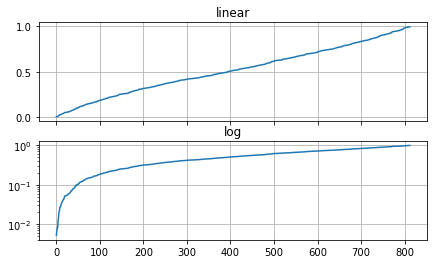

In [13]:
"""
Illustrate the scale transformations applied to axes, e.g. log, symlog, logit.
"""
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter

np.random.seed(1)
# make up some data in the interval ]0, 1[
y = np.random.normal(loc=0.5, scale=0.4, size=1000)
y = y[(y > 0) & (y < 1)]
y.sort()
x = np.arange(len(y))

# plot with various axes scales
fig, axs = plt.subplots(2, 1, sharex=True)
fig.subplots_adjust(left=0.08, right=0.98, wspace=0.3)

# linear
ax = axs[0]
ax.plot(x, y)
ax.set_yscale('linear')
ax.set_title('linear')
ax.grid(True)


# log
ax = axs[1]
ax.plot(x, y)
ax.set_yscale('log')
ax.set_title('log')
ax.grid(True)




plt.show()

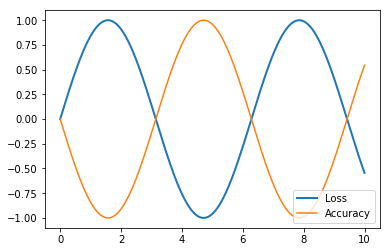

In [18]:
import numpy as np
import matplotlib.pyplot as plt


x = np.linspace(0, 10, 500)
fig, ax = plt.subplots()
line1, = ax.plot(x, np.sin(x), '-', linewidth=2,
                 label='Loss')
line2, = ax.plot(x, -1 * np.sin(x),
                 label='Accuracy')
ax.legend(loc='lower right')
plt.show()

In [20]:
(None,)+(2, 3, 4)

(None, 2, 3, 4)